0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:10


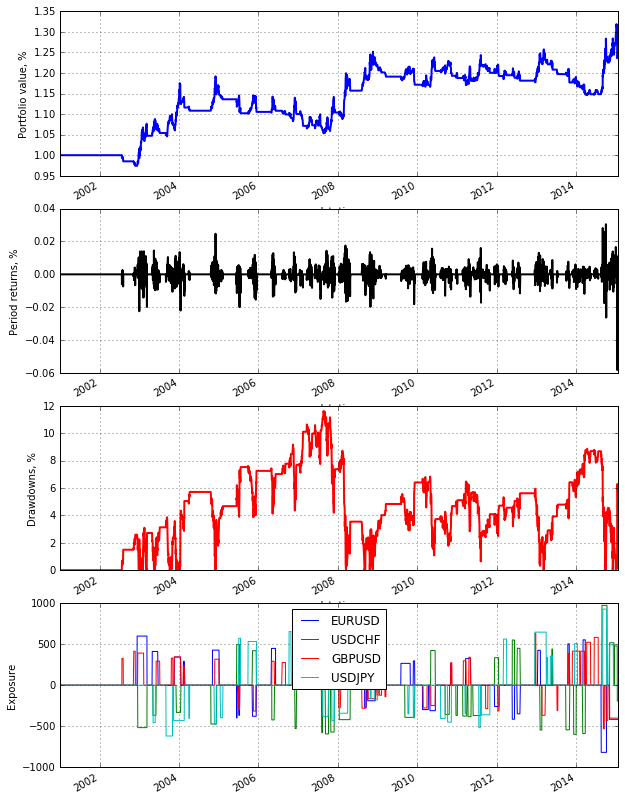

,Base Stats
#Trades,133.000000
CAGR(%),1.635758
Avg trade(R),0.134491
Daily Sharpe,0.307848


In [2]:
import queue
import matplotlib.pyplot as plt
from datetime import datetime

from broker.data_handlers.arctic_data_handler import ArcticDatabaseDataHandler
from broker.execution_handler import SimulatedExecution
from portfolio import Portfolio
from backtest import BacktestEngine
from broker.account import SimulatedAccount
from strategy_manager import StrategyManager

from strategies.donchian_breakout import DonchianBreakout
from strategies.RSI_MOM_2 import RSI_Trading_Strategy
from strategies.PA_test import PA_Test

%matplotlib inline

#PARAMETERS
symbol_list= ['EURUSD','GBPUSD','USDJPY','USDCHF']
risk= 0.01
equity = 1000.0
leverage = 20
start_date= datetime(2001,1,1)
end_date= datetime(2011,12,31)


events_queue = queue.Queue()
account = SimulatedAccount(equity,leverage,'USD')
#prices = DatabaseDataHandler(events_queue=events_queue, symbol_list=symbol_list,account=account,db_adress='localhost',
                             #timeframe='D1', start_date=start_date,end_date=end_date,data_vendor='FX')
#prices = CSVDataHandler(events_queue,symbol_list,account,start_date = start_date,end_date = end_date)
prices= ArcticDatabaseDataHandler(events_queue=events_queue, symbol_list=symbol_list,account=account,db_adress='localhost',
                             timeframe='D1', start_date=start_date,end_date=end_date,data_vendor='FX')

strategy_4 = DonchianBreakout(prices,events_queue, entry_lookback=200, exit_lookback=100, atr_stop=3.,TP_atr=5.,name='DC_200x100')
#strategy_5 = RSI_Trading_Strategy(prices,events_queue,rsi_lookback=15, rsi_trigger_offset=25,trailing_stop_atr=1.8, take_profit_atr=3)
#strategy_6 = PA_Test(prices,events_queue,atr_stop=1.8,TP_atr=4.)

manager = StrategyManager([strategy_4])


portfolio = Portfolio(events_queue=events_queue, prices=prices,account=account,strat_manager=manager,risk_per_trade = risk)
portfolio.open_trades.clear()
portfolio.compound=False

execution = SimulatedExecution(events_queue,prices,spread=0.0003)
backtest = BacktestEngine(events_queue, prices, execution, portfolio, manager)

backtest.backtest_trading()
backtest.stats.plot_performance()
backtest.stats.output_base_stats()

# Backtest Analysis

In [3]:
backtest.stats.output_full_stats()

,All Trades,Long only,Short only
#Trades,133,68,65
CAGR(%),1.63576,NaN,NaN
Avg trade(R),0.134491,0.158206,0.109682
Daily Sharpe,0.307848,NaN,NaN
Max Drawdown(%),11.6258,NaN,NaN
Avg Duration,33 days 04:52:19.849624,32 days 16:56:28.235294,33 days 17:21:13.846153
Exposure %,47.6425,23.6568,23.9857
Win Rate %,44.3609,0.455882,0.430769
Avg Win,1.3246,1.35165,1.29465
Avg Loss,-0.814382,-0.841711,-0.787054


In [4]:
trades = backtest.stats.trades
trades_per_years = trades.open_date.groupby(trades.open_date.dt.year).count()
ce = backtest.stats.cagr /trades_per_years.mean() *100
print('Cost efficiency %0.2f' %ce)
print('Avg trades_per_years',trades_per_years.mean())



Cost efficiency 0.16
Avg trades_per_years 10.23076923076923


In [5]:
from scipy import stats
import numpy as np

def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""
    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    return r_value**2

hist = backtest.stats.history
print("R-squared %0.2f" %rsquared(np.arange(len(hist.equity)),hist.equity))

R-squared 0.74


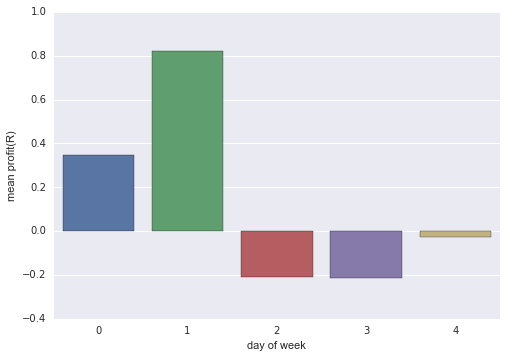

In [6]:
import seaborn as sns
import pandas as pd

df_weekday = trades[['open_date','close_date','profit_R']].reset_index()
df_weekday['open_weekday']=df_weekday.open_date.dt.dayofweek
df_weekday['close_weekday']=df_weekday.close_date.dt.dayofweek
weekday_group = df_weekday.groupby(by='open_weekday')

results = pd.DataFrame(index = weekday_group.profit_R.sum().index)
results['mean'] = weekday_group.profit_R.mean()
sns.barplot(x=results.index,y='mean',data=results)
sns.axlabel(xlabel='day of week',ylabel='mean profit(R)')

# Strategies analysis

In [7]:
strat_equities = pd.DataFrame()
trades['returns'] = trades.profit_R * risk

for strategy in strategies:
    name = strategy.identifier
    equity = (1+trades.profit_R[trades.strategy == name]).cumprod()
    strat_equities = pd.concat([strat_equities,equity],axis=1)
strat_equities.fillna(method='pad',inplace=True)

NameError: name 'strategies' is not defined

In [ ]:
strat_equities